In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage import feature, filters, transform
from tqdm.notebook import tqdm

In [2]:
def crop(im, crop_percent=0.3):
    crop = int((crop_percent * len(im[0])) // 2)
    return im[crop:(len(im[0])-crop),crop:(len(im[1])-crop)]
    
def into_channels(im):
    im = sk.img_as_float(im)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]
    
    return b, g, r

def into_edges(channels, alg=filters.roberts):
    return [alg(crop(channel)) for channel in channels]

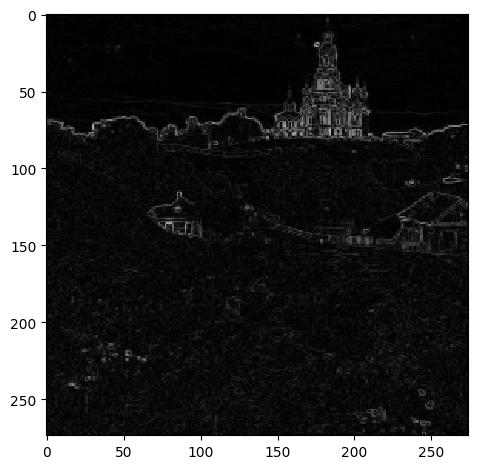

In [9]:
sample_edges_blue_channel, _, _ = into_edges(into_channels(skio.imread('data/cathedral.jpg')))
skio.imshow(sample_edges_blue_channel)
skio.imsave('out/cathedral_blue_edges.jpg', (sample_edges_blue_channel * 255).astype(np.uint8))
skio.imsave('out/cathedral_blue_channel.jpg', crop((into_channels(skio.imread('data/cathedral.jpg'))[0]) * 255).astype(np.uint8))

In [4]:
# translates the matrix by x and y.
def shift(m, x, y):
    return np.roll(np.roll(m, x, axis=0), y, axis=1)

import itertools

# returns the best shift for matrix b to minimize distance (measured by ncc) from a.
# the search space is a delta*2 by delta*2 square.
def pair_align(a, b, delta):
    # pre-ravel a
    a = np.ravel(a)
    def ncc(a, b):
        return a.dot(np.ravel(b))
    
    search_space = itertools.product(range(-delta, delta+1), repeat=2)
    return np.asarray(max(search_space, key=lambda coords: ncc(a, shift(b, *coords))))

# returns the best shifts for g and r channels to align with b channel.
def channel_align(b, g, r, delta):
    b_edges, g_edges, r_edges = into_edges([b, g, r])
    return pair_align(b_edges, g_edges, delta), pair_align(b_edges, r_edges, delta)

# downscales the matrix by a factor of 2.
def downscale(m):
    return transform.downscale_local_mean(m, (2, 2))

# recursively aligns the b, g, r channels.
# returns the best shifts for g and r channels to align with b channel.
# base_delta specifies the search space (delta) in the base case, 
# which will be a square with side length (2 * base_delta).
# delta is halved at each higher resolution for constant runtime.
def pyramid_align(b, g, r, base_delta=32, delta=None):
    # base case: image is smaller than 512x512. (assuming square-ish images).
    if len(b[0]) < 512:
        return channel_align(b, g, r, base_delta)
    else:
        if delta == None:
            steps_till_512 = int(np.log2(len(b[0]) / 512)) + 1
            delta = max(4, base_delta // (2 ** steps_till_512))

        # recurse here. we double delta to keep work constant. 
        # though, delta is capped (at base_delta) because it's not useful to have a delta that covers most of the image.
        g_shift_d, r_shift_d = pyramid_align(downscale(b), downscale(g), downscale(r), base_delta, delta*2)
        
        # we apply the alignment found for the downscaled image.
        # multiply the shifts by two to reverse the downscaling.
        g = shift(g, *(g_shift_d * 2))
        r = shift(r, *(r_shift_d * 2))

        g_shift, r_shift = channel_align(b, g, r, delta)

        # the final shift found at this step, which takes the downscaled shifts into account.
        return (g_shift_d * 2) + g_shift, (r_shift_d*2) + r_shift

def align_image(im_name):
    im = skio.imread('data/' + im_name)
    b, g, r = into_channels(im)
    g_shift, r_shift = pyramid_align(b, g, r, base_delta=32)

    g = shift(g, *g_shift)
    r = shift(r, *r_shift)

    return np.dstack([r, g, b]), g_shift, r_shift

In [5]:
import os

for file in os.listdir('data'):
    if file[-3:] in ['jpg', 'tif']:
        im, g_shift, r_shift = align_image(file)
        fname = 'out/' + file[:-3] + 'jpg'
        skio.imsave(fname, (im * 255).astype(np.uint8))
        print('saved to', fname, 'using g shift', g_shift, 'and r_shift', r_shift)

saved to out/cathedral.jpg using g shift [5 2] and r_shift [12  3]
saved to out/church.jpg using g shift [25  4] and r_shift [58 -4]
saved to out/emir.jpg using g shift [49 24] and r_shift [107  40]
saved to out/harvesters.jpg using g shift [60 17] and r_shift [124  13]
saved to out/icon.jpg using g shift [42 17] and r_shift [90 23]
saved to out/lady.jpg using g shift [57  9] and r_shift [120  13]
saved to out/melons.jpg using g shift [80 10] and r_shift [177  13]
saved to out/monastery.jpg using g shift [-3  2] and r_shift [3 2]
saved to out/onion_church.jpg using g shift [52 25] and r_shift [107  35]
saved to out/sculpture.jpg using g shift [ 33 -11] and r_shift [140 -27]
saved to out/self_portrait.jpg using g shift [78 29] and r_shift [175  36]
saved to out/three_generations.jpg using g shift [54 12] and r_shift [111   8]
saved to out/tobolsk.jpg using g shift [3 2] and r_shift [6 3]
saved to out/train.jpg using g shift [42  2] and r_shift [86 29]


In [11]:
for file in os.listdir('data/selected_data'):
    if file[-3:] in ['jpg', 'tif']:
        im, g_shift, r_shift = align_image('selected_data/' + file)
        fname = 'out/' + file[:-3] + 'jpg'
        skio.imsave(fname, (im * 255).astype(np.uint8))
        print('saved to', fname, 'using g shift', g_shift, 'and r_shift', r_shift)

saved to out/etruscan_vase.jpg using g shift [24 -2] and r_shift [113  -2]
saved to out/isfandiyar.jpg using g shift [38  9] and r_shift [ 95 -10]
saved to out/little_russia.jpg using g shift [-23   9] and r_shift [-34  11]
